In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute, Aer
from qiskit import IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
import numpy as np
import random

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# Teleporting Qubits

In [2]:
def QuantumTeleport(initial_state):
    # declare the 3 qubits; one to teleport and the other two to entangle
    q = QuantumRegister(3, name = 'q')
    
    # initialize the classical registers
    
    # crz checks whether to operate Z on the 3rd qubit after the gates
    crz = ClassicalRegister(1, name = 'crz')
    # crx check whether to operate X on the 3rd qubit after the gates
    crx = ClassicalRegister(1, name = 'crx')
    # c is the final measurement of the 3rd quibit
    c = ClassicalRegister(1, name = 'c')
    
    # initialize our quantum circuit
    qc = QuantumCircuit(q,crz,crx,c, name ='qc')
    
    # store the initial state into qubit 1, which will be teleported to qubit 3
    qc.initialize(initial_state, 0)
    qc.i(q[1]) # makes the visuals line up
    qc.i(q[2]) # makes the visuals line up

    # create a bell pair
    qc.i(q[0]) # makes the visuals line up
    qc.h(q[1]) # applies a hadamard to the second qubit
    qc.cx(q[1],q[2]) # applies a CNOT to the second(control) and third(target) qubits to entangle them together
    qc.barrier() # separates the stages of the circuit

    # prepare to teleport
    qc.cx(q[0],q[1]) # applies a CNOT to the first(control) and second(target) qubits
    qc.h(q[0]) # applies a hadamard to the first qubit
    qc.i(q[1]) # makes the visuals line up
    qc.i(q[2]) # makes the visuals line up
    qc.i(q[2]) # makes the visuals line up
    qc.barrier() # separates the stages of the circuit
    
    # perform measurement on the first and second qubits
    qc.measure(q[0],crz) # measure qubit 1
    qc.measure(q[1],crx) # measure qubit 2
    
    # make necessary changes to the third qubit depending on the state of the first two
    qc.x(q[2]).c_if(crx, 1) # Apply X gate to qubit 3 if qubit 2 is in state |1>
    qc.z(q[2]).c_if(crz, 1) # Apply Z gate to qubit 3 if qubit 1 is in state |1>

    # perform measurement on the third qubit to see if we teleported correctly
    qc.measure(q[2],c) # measure qubit 3
    
    # use the classical simulator
    backend = Aer.get_backend('qasm_simulator') # classical simulator
    counts = execute(qc, backend, shots=16384).result().get_counts() # simulate a large set of data

    # draw the circuit
    print('Quantum Teleportation Circuit Diagram:')
    print(circuit_drawer(qc)) # ascii write out
    
    # calculate the probability amplitudes we result with on average
    total_0 = 0 # stores the total prob we find |0>
    total_1 = 0 # stores the total prob we find |1>
    for item in counts:
        if item[0] == '0': # check if we measured a |0> for the teleported qubit
            total_0 += counts[item]/16384 # get the probability and add to total number of |0>'s
        else: # check if we measured a |1> for the teleported qubit
            total_1 += counts[item]/16384 # get the probability and add to total number of |1>'s

    total_0 = np.sqrt(total_0) # turn into probability amplitude
    total_1 = np.sqrt(total_1) # turn into probability amplitude
    
    print('The state we are trying to send is: %s|0>' %str(initial_state[0]), '+ %s|1>' % str(initial_state[1]))
    print('The state we resulted with is: %s|0>' %str(total_0), '+ %s|1>' % str(total_1))
    print()
    
    # calculate the % error of our teleportation
    if initial_state[0] == 0: # making sure we don't divide by zero if our initial state was just |1>
        print('The error in |0> is:', 0.0, '%') # in this case there is zero error no matter what
    else:
        print('The error in |0> is:', abs(1 - (total_0/initial_state[0]))*100, '%')
        
    if initial_state[1] == 0: # making sure we don't divide by zero if our initial state was just |0>
        print('The error in |1> is:', 0.0, '%') # in this case there is zero error no matter what
    else:
        print('The error in |1> is:', abs(1 - (total_1/initial_state[1]))*100, '%')
    
    return qc, counts

### Pure State |1>:

Quantum Teleportation Circuit Diagram:
       ┌─────────────────┐┌───┐      ░      ┌───┐ ░ ┌─┐                    
  q_0: ┤ Initialize(0,1) ├┤ I ├──────░───■──┤ H ├─░─┤M├────────────────────
       └──────┬───┬──────┘├───┤      ░ ┌─┴─┐├───┤ ░ └╥┘┌─┐                 
  q_1: ───────┤ I ├───────┤ H ├──■───░─┤ X ├┤ I ├─░──╫─┤M├─────────────────
              ├───┤       └───┘┌─┴─┐ ░ ├───┤├───┤ ░  ║ └╥┘ ┌───┐  ┌───┐ ┌─┐
  q_2: ───────┤ I ├────────────┤ X ├─░─┤ I ├┤ I ├─░──╫──╫──┤ X ├──┤ Z ├─┤M├
              └───┘            └───┘ ░ └───┘└───┘ ░  ║  ║  └─╥─┘  └─╥─┘ └╥┘
                                                     ║  ║    ║   ┌──╨──┐ ║ 
crz: 1/══════════════════════════════════════════════╩══╬════╬═══╡ 0x1 ╞═╬═
                                                     0  ║ ┌──╨──┐└─────┘ ║ 
crx: 1/═════════════════════════════════════════════════╩═╡ 0x1 ╞════════╬═
                                                        0 └─────┘        ║ 
  c: 1/══════════════════════════════════════════

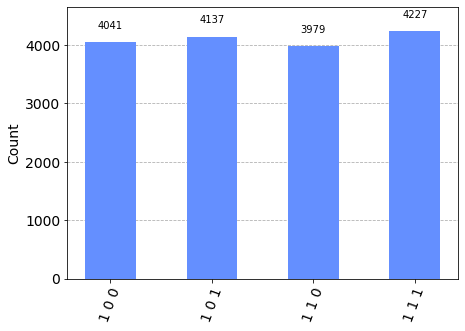

In [3]:
initial_state = [0,1] # teleport the state |1>
qc, counts = QuantumTeleport(initial_state) # collect data
plot_histogram(counts) # plot the results

In [ ]:
# Test on a quantum computer
# q = QuantumRegister(3, name = 'q')

qc = QuantumCircuit(3, 1)

qc.barrier()

# create a bell pair
qc.x(q[0])
qc.h(q[1]) # applies a hadamard to the second qubit
qc.cx(q[1],q[2]) # applies a CNOT to the second(control) and third(target) qubits to entangle them together

# prepare to teleport
qc.cx(q[0],q[1]) # applies a CNOT to the first(control) and second(target) qubits
qc.h(q[0]) # applies a hadamard to the first qubit
    
# make necessary changes to the third qubit depending on the state of the first two
qc.cz(0,2) # Apply Z gate to qubit 3 if qubit 1 is in state |1>
qc.cx(1,2) # Apply X gate to qubit 3 if qubit 2 is in state |1>

qc.measure(2, 0) # measure qubit 3

# The following was used from https://qiskit.org/textbook/ch-algorithms/teleportation.html
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
plot_histogram(exp_measurement_result)

### Mixed State |+>:

Quantum Teleportation Circuit Diagram:
       ┌─────────────────────────────┐┌───┐      ░      ┌───┐ ░ ┌─┐          »
  q_0: ┤ Initialize(0.70711,0.70711) ├┤ I ├──────░───■──┤ H ├─░─┤M├──────────»
       └────────────┬───┬────────────┘├───┤      ░ ┌─┴─┐├───┤ ░ └╥┘┌─┐       »
  q_1: ─────────────┤ I ├─────────────┤ H ├──■───░─┤ X ├┤ I ├─░──╫─┤M├───────»
                    ├───┤             └───┘┌─┴─┐ ░ ├───┤├───┤ ░  ║ └╥┘ ┌───┐ »
  q_2: ─────────────┤ I ├──────────────────┤ X ├─░─┤ I ├┤ I ├─░──╫──╫──┤ X ├─»
                    └───┘                  └───┘ ░ └───┘└───┘ ░  ║  ║  └─╥─┘ »
crz: 1/══════════════════════════════════════════════════════════╩══╬════╬═══»
                                                                 0  ║ ┌──╨──┐»
crx: 1/═════════════════════════════════════════════════════════════╩═╡ 0x1 ╞»
                                                                    0 └─────┘»
  c: 1/══════════════════════════════════════════════════════════════════════»
             

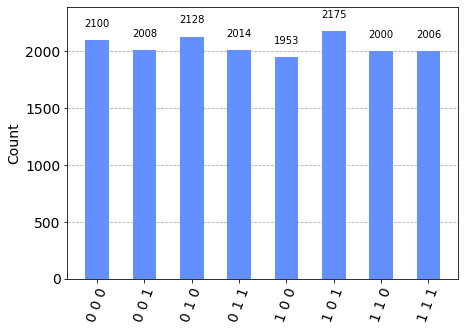

In [4]:
initial_state = [1/np.sqrt(2),1/np.sqrt(2)] # prepare the |+> state
qc, counts = QuantumTeleport(initial_state) # collect data
plot_histogram(counts) # plot the results

In [ ]:
# Test on a quantum computer

qc = QuantumCircuit(3, 1)

# create a bell pair
qc.h(q[0])
qc.h(q[1]) # applies a hadamard to the second qubit
qc.cx(q[1],q[2]) # applies a CNOT to the second(control) and third(target) qubits to entangle them together

# prepare to teleport
qc.cx(q[0],q[1]) # applies a CNOT to the first(control) and second(target) qubits
qc.h(q[0]) # applies a hadamard to the first qubit
    
# make necessary changes to the third qubit depending on the state of the first two
qc.cz(0,2) # Apply Z gate to qubit 3 if qubit 1 is in state |1>
qc.cx(1,2) # Apply X gate to qubit 3 if qubit 2 is in state |1>

qc.measure(2, 0) # measure the 3rd qubit 

# The following was used from https://qiskit.org/textbook/ch-algorithms/teleportation.html
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
plot_histogram(exp_measurement_result)

# Teleporting Entangled Qubits

In [5]:
def QuantumTeleportEntangled():
    # declare the 4 qubits
    q = QuantumRegister(4, name = 'q')
    
    # classical registers to check if the teleportation was successful
    c = ClassicalRegister(2, name = 'c')
    
    # crz checks whether to operate Z on the 3rd qubit after the gates
    crz = ClassicalRegister(1, name = 'crz')
    # crx check whether to operate X on the 3rd qubit after the gates
    crx = ClassicalRegister(1, name = 'crx')
    
    # initialize our quantum circuit
    qc = QuantumCircuit(q,crz,crx,c,name ='qc')

    # create our first bell pair |Ψ−⟩ab to be teleported 
    qc.h(q[0]) # applies a hadamard to the first qubit
    qc.cx(q[0],q[1]) # applies a CNOT to the first(control) and second(target) qubits to entangle them together
    qc.z(q[0]) # applies a Z gate to the first qubit
    qc.x(q[1]) # applies an X gate to the second qubit
    
    # create our second bell pair ∣Φ+⟩cd
    qc.i(q[2]) # makes the visuals line up
    qc.i(q[3]) # makes the visuals line up
    qc.h(q[2]) # applies a hadamard to the third qubit
    qc.cx(q[2],q[3]) # applies a CNOT to the third(control) and fourth(target) qubits to entangle them together
    qc.barrier() # separates the stages of the circuit
    
    #prepare to teleport
    qc.cx(q[1], q[2]) # applies a CNOT to the second(control) and third(target) qubits
    qc.h(q[1]) # applies a hadamard to the second qubit
    qc.i(q[0]) # makes the visuals line up
    qc.i(q[0]) # makes the visuals line up
    qc.i(q[2]) # makes the visuals line up
    qc.i(q[3]) # makes the visuals line up
    qc.i(q[3]) # makes the visuals line up
    qc.barrier() # separates the stages of the circuit
    
    # perform measurement on the second and third qubits
    qc.measure(q[1],crz) # measure qubit 2
    qc.measure(q[2],crx) # measure qubit 3
    
    qc.x(q[3]).c_if(crx, 1) # Apply X gate to qubit 4 if qubit 3 is in state |1>
    qc.z(q[3]).c_if(crz, 1) # Apply Z gate to qubit 4 if qubit 2 is in state |1>
    
    # perform measurement on the third qubit to see if we teleported correctly
    qc.i(q[0]) # makes the visuals line up
    qc.i(q[0]) # makes the visuals line up
    qc.measure(q[0],c[0]) # measure qubit 1
    qc.measure(q[3],c[1]) # measure qubit 4
    
    # use the classical simulator
    backend = Aer.get_backend('qasm_simulator') # classical simulator
    counts = execute(qc, backend, shots=16384).result().get_counts() # simulate a large set of data

    # draw the circuit
    print('Quantum Teleportation Circuit Diagram:')
    print(circuit_drawer(qc)) # ascii write out
    
    # calculate the probability amplitudes we result with on average
    total_01 = 0 # stores the total prob we find |01>
    total_10 = 0 # stores the total prob we find |10>
    for item in counts:
        if item [0:2] == '01': # check if we measured a |01> for the new entangled pair
            total_01 += counts[item]/16384 # get the probability and add to total number of |01>'s
        if item[0:2] == '10': # check if we measured a |10> for the new entangled pair
            total_10 += counts[item]/16384 # get the probability and add to total number of |10>'s

    total_01 = np.sqrt(total_01) # turn into probability amplitude
    total_10 = np.sqrt(total_10) # turn into probability amplitude
    
    print('The state we are trying to send is: %s|01>' %str(1/np.sqrt(2)), '- %s|10>' % str(1/np.sqrt(2)))
    print('The state we resulted with is: %s|01>' %str(total_01), '- %s|10>' % str(total_10))
    print()
    
    # calculate the % error of our teleportation
    print('The error in |01> is:', abs(1 - (total_01*np.sqrt(2)))*100, '%')
    print('The error in |10> is:', abs(1 - (total_10*np.sqrt(2)))*100, '%')
    
    return counts

### Example with |Ψ−⟩ab ⊗ ∣Φ+⟩cd:

Quantum Teleportation Circuit Diagram:
       ┌───┐     ┌───┐ ░ ┌───┐┌───┐ ░ ┌───┐┌───┐              ┌─┐   
  q_0: ┤ H ├──■──┤ Z ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├──────────────┤M├───
       └───┘┌─┴─┐├───┤ ░ └───┘├───┤ ░ └┬─┬┘└───┘              └╥┘   
  q_1: ─────┤ X ├┤ X ├─░───■──┤ H ├─░──┤M├─────────────────────╫────
       ┌───┐├───┤└───┘ ░ ┌─┴─┐├───┤ ░  └╥┘  ┌─┐                ║    
  q_2: ┤ I ├┤ H ├──■───░─┤ X ├┤ I ├─░───╫───┤M├────────────────╫────
       ├───┤└───┘┌─┴─┐ ░ ├───┤├───┤ ░   ║   └╥┘  ┌───┐  ┌───┐  ║ ┌─┐
  q_3: ┤ I ├─────┤ X ├─░─┤ I ├┤ I ├─░───╫────╫───┤ X ├──┤ Z ├──╫─┤M├
       └───┘     └───┘ ░ └───┘└───┘ ░   ║    ║   └─╥─┘  └─╥─┘  ║ └╥┘
                                        ║    ║     ║   ┌──╨──┐ ║  ║ 
crz: 1/═════════════════════════════════╩════╬═════╬═══╡ 0x1 ╞═╬══╬═
                                        0    ║  ┌──╨──┐└─────┘ ║  ║ 
crx: 1/══════════════════════════════════════╩══╡ 0x1 ╞════════╬══╬═
                                             0  └─────┘        ║

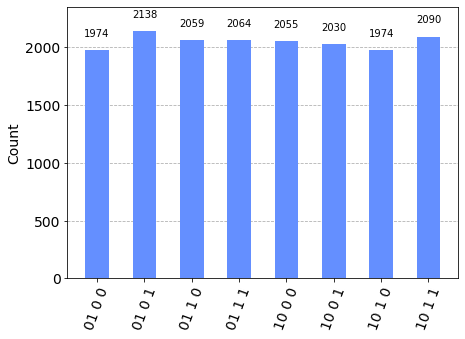

In [6]:
counts = QuantumTeleportEntangled()
plot_histogram(counts) # plot the results

In [ ]:
# Test on a quantum computer

qc = QuantumCircuit(4, 2)

# create a bell pair
qc.h(0) # applies a hadamard to the first qubit
qc.cx(0,1) # applies a CNOT to the first(control) and second(target) qubits to entangle them together
qc.z(0) # apply a Z gate to qubit 1
qc.x(1) # apply an X gate to qubit 1

# create a bell pair
qc.h(2) # applies a hadamard to the third qubit
qc.cx(2,3) # applies a CNOT to the third(control) and fourth(target) qubits to entangle them together

# prepare to teleport
qc.cx(1,2) # applies a CNOT to the second(control) and third(target) qubits
qc.h(1) # applies a hadamard to the first qubit
    
# make necessary changes to the fourth qubit depending on the state of the middle two
qc.cz(1,3) # Apply Z gate to qubit 4 if qubit 2 is in state |1>
qc.cx(2,3) # Apply X gate to qubit 4 if qubit 3 is in state |1>

qc.measure(0, 0)
qc.measure(3, 1)

# The following was used from https://qiskit.org/textbook/ch-algorithms/teleportation.html
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
plot_histogram(exp_measurement_result)

# Teleporting Twice

In [7]:
def TeleportTwice(initial_state):
    # declare the 3 qubits; one to teleport and the other two to entangle
    q = QuantumRegister(5, name = 'q')
    
    # initialize the classical registers
    
    # crz checks whether to operate Z on the 3rd qubit after the gates
    crz1 = ClassicalRegister(1, name = 'crz1')
    # crx check whether to operate X on the 3rd qubit after the gates
    crx1 = ClassicalRegister(1, name = 'crx1')
    # crz checks whether to operate Z on the 5th qubit after the gates
    crz2 = ClassicalRegister(1, name = 'crz2')
    # crx check whether to operate X on the 5th qubit after the gates
    crx2 = ClassicalRegister(1, name = 'crx2')
    # c is the final measurement of the 5th quibit
    c = ClassicalRegister(1, name = 'c')
    
    # initialize our quantum circuit
    qc = QuantumCircuit(q,crz1,crx1,crz2,crx2,c, name ='qc')
    
    # store the initial state into qubit 1, which will be teleported to qubit 3
    qc.initialize(initial_state, 0)
    qc.i(q[1]) # makes the visuals line up
    qc.i(q[2]) # makes the visuals line up

    # create a bell pair
    qc.i(q[0]) # makes the visuals line up
    qc.h(q[1]) # applies a hadamard to the second qubit
    qc.cx(q[1],q[2]) # applies a CNOT to the second(control) and third(target) qubits to entangle them together
    qc.barrier() # separates the stages of the circuit

    # prepare to teleport the first time
    qc.cx(q[0],q[1]) # applies a CNOT to the first(control) and second(target) qubits
    qc.h(q[0]) # applies a hadamard to the first qubit
    qc.i(q[1]) # makes the visuals line up
    qc.i(q[2]) # makes the visuals line up
    qc.i(q[2]) # makes the visuals line up
    qc.barrier() # separates the stages of the circuit
    
    # perform measurement on the first and second qubits
    qc.measure(q[0],crz1) # measure qubit 1
    qc.measure(q[1],crx1) # measure qubit 2
    
    # make necessary changes to the third qubit depending on the state of the first two
    qc.x(q[2]).c_if(crx1, 1) # Apply X gate to qubit 3 if qubit 2 is in state |1>
    qc.z(q[2]).c_if(crz1, 1) # Apply Z gate to qubit 3 if qubit 1 is in state |1>
    qc.barrier()
    
    # prepare to teleport the second time
    qc.cx(q[2],q[3]) # applies a CNOT to the third(control) and fourth(target) qubits
    qc.h(q[2]) # applies a hadamard to the third qubit
    qc.barrier() # separates the stages of the circuit
    
    # perform measurement on the third and fourth qubits
    qc.measure(q[2],crz2) # measure qubit 3
    qc.measure(q[3],crx2) # measure qubit 4
    
    # make necessary changes to the third qubit depending on the state of the previous two
    qc.x(q[4]).c_if(crx2, 1) # Apply X gate to qubit 5 if qubit 3 is in state |1>
    qc.z(q[4]).c_if(crz2, 1) # Apply Z gate to qubit 5 if qubit 2 is in state |1>

    # perform measurement on the fifth qubit to see if we teleported correctly
    qc.measure(q[4],c) # measure qubit 5
    
    # use the classical simulator
    backend = Aer.get_backend('qasm_simulator') # classical simulator
    counts = execute(qc, backend, shots=16384).result().get_counts() # simulate a large set of data

    # draw the circuit
    print('Quantum Teleportation Circuit Diagram:')
    print(circuit_drawer(qc)) # ascii write out
    
    # calculate the probability amplitudes we result with on average
    total_0 = 0 # stores the total prob we find |0>
    total_1 = 0 # stores the total prob we find |1>
    for item in counts:
        if item[0] == '0': # check if we measured a |0> for the teleported qubit
            total_0 += counts[item]/16384 # get the probability and add to total number of |0>'s
        else: # check if we measured a |1> for the teleported qubit
            total_1 += counts[item]/16384 # get the probability and add to total number of |1>'s

    total_0 = np.sqrt(total_0) # turn into probability amplitude
    total_1 = np.sqrt(total_1) # turn into probability amplitude
    
    print('The state we are trying to send is: %s|0>' %str(initial_state[0]), '+ %s|1>' % str(initial_state[1]))
    print('The state we resulted with is: %s|0>' %str(total_0), '+ %s|1>' % str(total_1))
    print()
    
    # calculate the % error of our teleportation
    if initial_state[0] == 0: # making sure we don't divide by zero if our initial state was just |1>
        print('The error in |0> is:', 0.0, '%') # in this case there is zero error no matter what
    else:
        print('The error in |0> is:', abs(1 - (total_0/initial_state[0]))*100, '%')
        
    if initial_state[1] == 0: # making sure we don't divide by zero if our initial state was just |0>
        print('The error in |1> is:', 0.0, '%') # in this case there is zero error no matter what
    else:
        print('The error in |1> is:', abs(1 - (total_1/initial_state[1]))*100, '%')
    
    return qc, counts

### Example with |+>:

Quantum Teleportation Circuit Diagram:
        ┌─────────────────────────────┐┌───┐      ░      ┌───┐ ░ ┌─┐          »
   q_0: ┤ Initialize(0.70711,0.70711) ├┤ I ├──────░───■──┤ H ├─░─┤M├──────────»
        └────────────┬───┬────────────┘├───┤      ░ ┌─┴─┐├───┤ ░ └╥┘┌─┐       »
   q_1: ─────────────┤ I ├─────────────┤ H ├──■───░─┤ X ├┤ I ├─░──╫─┤M├───────»
                     ├───┤             └───┘┌─┴─┐ ░ ├───┤├───┤ ░  ║ └╥┘ ┌───┐ »
   q_2: ─────────────┤ I ├──────────────────┤ X ├─░─┤ I ├┤ I ├─░──╫──╫──┤ X ├─»
                     └───┘                  └───┘ ░ └───┘└───┘ ░  ║  ║  └─╥─┘ »
   q_3: ──────────────────────────────────────────░────────────░──╫──╫────╫───»
                                                  ░            ░  ║  ║    ║   »
   q_4: ──────────────────────────────────────────░────────────░──╫──╫────╫───»
                                                  ░            ░  ║  ║    ║   »
crz1: 1/══════════════════════════════════════════════════════════╩══╬════╬═══»
 

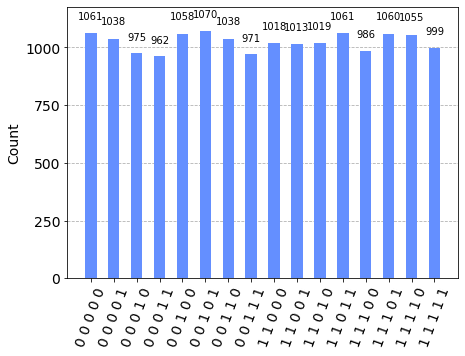

In [8]:
initial_state = [1/np.sqrt(2),1/np.sqrt(2)] # prepare the |+> state
qc, counts = TeleportTwice(initial_state) # collect data
plot_histogram(counts) # plot the results

In [ ]:
# Test on a quantum computer

qc = QuantumCircuit(5, 1)

qc.barrier()

# create a bell pair
qc.h(0) # make the |+> state
qc.h(1) # applies a hadamard to the second qubit
qc.cx(1,2) # applies a CNOT to the second(control) and third(target) qubits to entangle them together

# prepare to teleport the first time
qc.cx(0,1) # applies a CNOT to the first(control) and second(target) qubits
qc.h(0) # applies a hadamard to the first qubit
    
# make necessary changes to the third qubit depending on the state of the first two
qc.cz(0,2) # Apply Z gate to qubit 3 if qubit 2 is in state |1>
qc.cx(1,2) # Apply X gate to qubit 3 if qubit 1 is in state |1>

# prepare to teleport the second time
qc.cx(2,3) # applies a CNOT to the third(control) and fourth(target) qubits
qc.h(2) # applies a hadamard to the third qubit
    
# make necessary changes to the fifth qubit depending on the state of the previous two
qc.cz(2,4) # Apply Z gate to qubit 5 if qubit 3 is in state |1>
qc.cx(3,4) # Apply X gate to qubit 5 if qubit 4 is in state |1>

qc.measure(4, 0)

# The following was used from https://qiskit.org/textbook/ch-algorithms/teleportation.html
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
plot_histogram(exp_measurement_result)